In [14]:
# !python -c "import monai" || pip install -q "monai-weekly[nibabel]"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

^C


In [2]:
import monai
import matplotlib.pyplot as plt
from monai.utils import first, set_determinism
from monai.transforms import (Activations, Activationsd, AsDiscrete, AsDiscreted, EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged,
    Orientationd, RandCropByPosNegLabeld, SaveImaged, ScaleIntensityRanged, Spacingd, Invertd, RandSpatialCropd, RandFlipd, RandScaleIntensityd,
    EnsureTyped, Orientationd, Resized, RandShiftIntensityd, RandCropByLabelClassesd,RandRotate90d)
from monai.handlers.utils import from_engine

from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss
from monai.inferers import sliding_window_inference
from monai.handlers.utils import from_engine
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, ThreadDataLoader, set_track_meta, get_track_meta
from monai.config import print_config
from monai.apps import download_and_extract
from monai.networks.nets import UNETR

from tqdm import tqdm
import time
import scipy.io as sio
import matplotlib.pyplot as plt
import tempfile, shutil, os, glob, time
import numpy as np
import nibabel as nib
import torch

c:\Users\jnk50\Anaconda3\envs\vit\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jnk50\Anaconda3\envs\vit\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
torch.cuda.is_available()

True

In [3]:
print_config()
torch.cuda.empty_cache()

MONAI version: 1.0.1
Numpy version: 1.23.5
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: c:\Users\jnk50\Anaconda3\envs\vit\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.10.0
gdown version: 4.5.3
TorchVision version: 0.13.1a0
tqdm version: 4.64.1
lmdb version: 1.2.1
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.4.1
transformers version: 4.24.0
mlflow version: 1.30.0
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

# root_dir = r"C:\Users\jnk50\Desktop\MMH_Vit\Binary_Arteries_only"
print(root_dir)

C:\Users\jnk50\AppData\Local\Temp\tmpme6jze_f


In [3]:
# image = sorted([f for f in glob.iglob(r"C:\Users\jnk50\Desktop\MMH_Vit\MMH_NIFTI\*\*_img.nii.gz")])
# labels = sorted([f for f in glob.iglob(r"C:\Users\jnk50\Desktop\MMH_Vit\MMH_NIFTI\*\*_arteries_only.nii.gz")])

# For Cropped Images and Masks
image = sorted([f for f in glob.iglob(r"C:\Users\jnk50\Desktop\MMH_Vit\MMH_NIFTI_crop\img\*_crop_tight.nii.gz")])
labels = sorted([f for f in glob.iglob(r"C:\Users\jnk50\Desktop\MMH_Vit\MMH_NIFTI_crop\label\*_mask_crop_tight.nii.gz")])

data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(image, labels)]

In [5]:
data_dicts[0]

{'image': 'C:\\Users\\jnk50\\Desktop\\MMH_Vit\\MMH_NIFTI_crop\\img\\MMH006_crop_tight.nii.gz',
 'label': 'C:\\Users\\jnk50\\Desktop\\MMH_Vit\\MMH_NIFTI_crop\\label\\MMH006_mask_crop_tight.nii.gz'}

In [6]:
test_files, val_files, train_files = data_dicts[0:16], data_dicts[-67:-55], data_dicts[-55:]
print(len(train_files), len(val_files), len(test_files))

55 12 16


In [8]:
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-250, a_max=600,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        # Spacingd(
        #     keys=["image", "label"],
        #     pixdim=(0.75, 0.75, 1.5),
        #     mode=("bilinear", "nearest"),
        # ), 
        # Results in 229 229 270 for non-cropped spacing to 1,1,0.5
        # Results in 143 124 160 for cropped spacing to 0.75 0.75 1.5
        CropForegroundd(keys=["image", "label"], source_key="image"), 
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128, 128, 128),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        
        RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),
        RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),
        RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),

        EnsureTyped(keys=["image", "label"], track_meta=False), # Optmized 
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-250, a_max=600,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        # Spacingd(
        #     keys=["image", "label"],
        #     pixdim=(0.75, 0.75, 1.5),
        #     mode=("bilinear", "nearest"),
        # ), 
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"], track_meta=True), # Optmized 
    ]
)

In [9]:
# print(type(train_transform(train_files[0])[0]['image']))
# print(type(val_transform(val_files[0])['image']))

In [10]:
train_ds = CacheDataset(data=train_files, transform=train_transform, cache_num=12, 
                        cache_rate=1.0, num_workers=8, copy_cache=False)
train_loader = ThreadDataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

val_ds = CacheDataset(data=val_files, transform=val_transform, cache_num=6, 
                      cache_rate=1.0, num_workers=3, copy_cache=False)
val_loader = ThreadDataLoader(val_ds, batch_size=1, num_workers=0)

Loading dataset: 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]


In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(128, 128, 128),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.5,
).to(device)

In [13]:
# vit_dict = torch.load(r'C:\Users\jnk50\Desktop\MMH_Vit\vitautoenc_weights.pt')
# vit_weights = vit_dict["state_dict"]
# model_dict = model.vit.state_dict()
# vit_weights = {k: v for k, v in vit_weights.items() if k in model_dict}
# model_dict.update(vit_weights)
# model.vit.load_state_dict(model_dict)
# del model_dict, vit_weights, vit_dict
# print("Using pretrained self-supervied TCIA UNETR backbone weights !")

In [14]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [15]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (128,128,128), 16, model, overlap=0.25)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [16]:
start_time = time.time()

max_iterations = 6600
eval_num = 110
post_label = AsDiscrete(to_onehot=2)
post_pred = AsDiscrete(argmax=True, to_onehot=2)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )

print("Process finished --- %s seconds ---" % (time.time() - start_time))

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (110 / 6600 Steps) (loss=0.70194):  96%|█████████▋| 27/28 [00:30<00:04,  4.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.669266939163208 Current Avg. Dice: 0.669266939163208


Training (220 / 6600 Steps) (loss=0.71008):  89%|████████▉ | 25/28 [00:21<00:06,  2.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6830161213874817 Current Avg. Dice: 0.6830161213874817


Training (330 / 6600 Steps) (loss=0.69026):  82%|████████▏ | 23/28 [00:20<00:10,  2.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7084565162658691 Current Avg. Dice: 0.7084565162658691


Training (440 / 6600 Steps) (loss=0.58872):  75%|███████▌  | 21/28 [00:19<00:15,  2.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7110200524330139 Current Avg. Dice: 0.7110200524330139


Training (550 / 6600 Steps) (loss=0.53438):  68%|██████▊   | 19/28 [00:17<00:19,  2.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7604363560676575 Current Avg. Dice: 0.7604363560676575


Training (660 / 6600 Steps) (loss=0.56221):  61%|██████    | 17/28 [00:16<00:24,  2.22s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7820773124694824 Current Avg. Dice: 0.7820773124694824


Training (770 / 6600 Steps) (loss=0.81907):  54%|█████▎    | 15/28 [00:15<00:29,  2.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7868297696113586 Current Avg. Dice: 0.7868297696113586


Training (880 / 6600 Steps) (loss=0.48134):  46%|████▋     | 13/28 [00:14<00:33,  2.21s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8199930191040039 Current Avg. Dice: 0.8199930191040039


Training (990 / 6600 Steps) (loss=0.50183):  39%|███▉      | 11/28 [00:12<00:37,  2.22s/it]

Model Was Saved ! Current Best Avg. Dice: 0.86932373046875 Current Avg. Dice: 0.86932373046875


Training (1100 / 6600 Steps) (loss=0.47784):  32%|███▏      | 9/28 [00:12<00:43,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.86932373046875 Current Avg. Dice: 0.850273609161377


Training (1210 / 6600 Steps) (loss=0.39923):  25%|██▌       | 7/28 [00:09<00:48,  2.33s/it]

Model Was Saved ! Current Best Avg. Dice: 0.881291389465332 Current Avg. Dice: 0.881291389465332


Training (1320 / 6600 Steps) (loss=0.56125):  18%|█▊        | 5/28 [00:08<00:57,  2.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.881291389465332 Current Avg. Dice: 0.8641365170478821


Training (1430 / 6600 Steps) (loss=0.31918):  11%|█         | 3/28 [00:07<01:18,  3.12s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8971222043037415 Current Avg. Dice: 0.8971222043037415


Training (1540 / 6600 Steps) (loss=0.37497):   4%|▎         | 1/28 [00:05<02:39,  5.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8971222043037415 Current Avg. Dice: 0.8952059149742126


Training (1650 / 6600 Steps) (loss=0.43709):  96%|█████████▋| 27/28 [00:23<00:02,  2.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8971222043037415 Current Avg. Dice: 0.8906590342521667


Training (1760 / 6600 Steps) (loss=0.52539):  89%|████████▉ | 25/28 [00:21<00:06,  2.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8996757864952087 Current Avg. Dice: 0.8996757864952087


Training (1870 / 6600 Steps) (loss=0.25209):  82%|████████▏ | 23/28 [00:20<00:10,  2.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9015653729438782 Current Avg. Dice: 0.9015653729438782


Training (1980 / 6600 Steps) (loss=0.22629):  75%|███████▌  | 21/28 [00:19<00:15,  2.21s/it]

Model Was Saved ! Current Best Avg. Dice: 0.915719747543335 Current Avg. Dice: 0.915719747543335


Training (2090 / 6600 Steps) (loss=0.38355):  68%|██████▊   | 19/28 [00:18<00:18,  2.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.915719747543335 Current Avg. Dice: 0.9142696857452393


Training (2200 / 6600 Steps) (loss=0.48244):  61%|██████    | 17/28 [00:16<00:23,  2.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.915719747543335 Current Avg. Dice: 0.9002131819725037


Training (2310 / 6600 Steps) (loss=0.45110):  54%|█████▎    | 15/28 [00:15<00:28,  2.20s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9175364971160889 Current Avg. Dice: 0.9175364971160889


Training (2420 / 6600 Steps) (loss=0.25140):  46%|████▋     | 13/28 [00:14<00:32,  2.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9175364971160889 Current Avg. Dice: 0.9153659343719482


Training (2530 / 6600 Steps) (loss=0.20877):  39%|███▉      | 11/28 [00:12<00:37,  2.21s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9217283725738525 Current Avg. Dice: 0.9217283725738525


Training (2640 / 6600 Steps) (loss=0.30897):  32%|███▏      | 9/28 [00:11<00:41,  2.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9217283725738525 Current Avg. Dice: 0.9205246567726135


Training (2750 / 6600 Steps) (loss=0.28372):  25%|██▌       | 7/28 [00:10<00:50,  2.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9224990010261536 Current Avg. Dice: 0.9224990010261536


Training (2860 / 6600 Steps) (loss=0.29733):  18%|█▊        | 5/28 [00:09<00:58,  2.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9229283928871155 Current Avg. Dice: 0.9229283928871155


Training (2970 / 6600 Steps) (loss=0.25608):  11%|█         | 3/28 [00:07<01:16,  3.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9229862689971924 Current Avg. Dice: 0.9229862689971924


Training (3080 / 6600 Steps) (loss=0.45299):   4%|▎         | 1/28 [00:06<02:49,  6.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9229862689971924 Current Avg. Dice: 0.9172499775886536


Training (3190 / 6600 Steps) (loss=0.19409):  96%|█████████▋| 27/28 [00:22<00:02,  2.22s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9237775802612305 Current Avg. Dice: 0.9237775802612305


Training (3300 / 6600 Steps) (loss=0.42523):  89%|████████▉ | 25/28 [00:21<00:06,  2.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9255698323249817 Current Avg. Dice: 0.9255698323249817


Training (3410 / 6600 Steps) (loss=0.15641):  82%|████████▏ | 23/28 [00:21<00:11,  2.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9286675453186035 Current Avg. Dice: 0.9286675453186035


Training (3520 / 6600 Steps) (loss=0.20076):  75%|███████▌  | 21/28 [00:18<00:14,  2.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9286675453186035 Current Avg. Dice: 0.9283716082572937


Training (3630 / 6600 Steps) (loss=0.35260):  68%|██████▊   | 19/28 [00:17<00:19,  2.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9286675453186035 Current Avg. Dice: 0.926701545715332


Training (3740 / 6600 Steps) (loss=0.25740):  61%|██████    | 17/28 [00:16<00:23,  2.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9286675453186035 Current Avg. Dice: 0.9273474812507629


Training (3850 / 6600 Steps) (loss=0.26570):  54%|█████▎    | 15/28 [00:15<00:29,  2.26s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9288218021392822 Current Avg. Dice: 0.9288218021392822


Training (3960 / 6600 Steps) (loss=0.22789):  46%|████▋     | 13/28 [00:14<00:33,  2.22s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9315228462219238 Current Avg. Dice: 0.9315228462219238


Training (4070 / 6600 Steps) (loss=0.36969):  39%|███▉      | 11/28 [00:12<00:36,  2.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9315228462219238 Current Avg. Dice: 0.9282826781272888


Training (4180 / 6600 Steps) (loss=0.37712):  32%|███▏      | 9/28 [00:11<00:41,  2.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9315228462219238 Current Avg. Dice: 0.929441511631012


Training (4290 / 6600 Steps) (loss=0.27940):  25%|██▌       | 7/28 [00:10<00:47,  2.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9315228462219238 Current Avg. Dice: 0.9287341237068176


Training (4400 / 6600 Steps) (loss=0.20897):  18%|█▊        | 5/28 [00:08<00:58,  2.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9317510724067688 Current Avg. Dice: 0.9317510724067688


Training (4510 / 6600 Steps) (loss=0.24504):  11%|█         | 3/28 [00:07<01:13,  2.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9317510724067688 Current Avg. Dice: 0.9275620579719543


Training (4620 / 6600 Steps) (loss=0.27063):   4%|▎         | 1/28 [00:06<02:57,  6.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9334226250648499 Current Avg. Dice: 0.9334226250648499


Training (4730 / 6600 Steps) (loss=0.32006):  96%|█████████▋| 27/28 [00:23<00:02,  2.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9334226250648499 Current Avg. Dice: 0.9306703209877014


Training (4840 / 6600 Steps) (loss=0.25910):  89%|████████▉ | 25/28 [00:21<00:06,  2.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9334226250648499 Current Avg. Dice: 0.9314103722572327


Training (4950 / 6600 Steps) (loss=0.16532):  82%|████████▏ | 23/28 [00:20<00:10,  2.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9334226250648499 Current Avg. Dice: 0.9311039447784424


Training (5060 / 6600 Steps) (loss=0.24513):  75%|███████▌  | 21/28 [00:19<00:14,  2.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9334226250648499 Current Avg. Dice: 0.9293001294136047


Training (5170 / 6600 Steps) (loss=0.23647):  68%|██████▊   | 19/28 [00:18<00:19,  2.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9334226250648499 Current Avg. Dice: 0.9310362339019775


Training (5280 / 6600 Steps) (loss=0.19878):  61%|██████    | 17/28 [00:16<00:23,  2.15s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9346876740455627 Current Avg. Dice: 0.9346876740455627


Training (5390 / 6600 Steps) (loss=0.27390):  54%|█████▎    | 15/28 [00:15<00:28,  2.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9346876740455627 Current Avg. Dice: 0.9319970607757568


Training (5500 / 6600 Steps) (loss=0.35778):  46%|████▋     | 13/28 [00:13<00:31,  2.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9346876740455627 Current Avg. Dice: 0.9312751293182373


Training (5610 / 6600 Steps) (loss=0.19479):  39%|███▉      | 11/28 [00:12<00:37,  2.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9346876740455627 Current Avg. Dice: 0.9311184883117676


Training (5720 / 6600 Steps) (loss=0.22688):  32%|███▏      | 9/28 [00:11<00:42,  2.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9346876740455627 Current Avg. Dice: 0.9318220019340515


Training (5830 / 6600 Steps) (loss=0.14373):  25%|██▌       | 7/28 [00:09<00:46,  2.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9346876740455627 Current Avg. Dice: 0.9325375556945801


Training (5940 / 6600 Steps) (loss=0.36608):  18%|█▊        | 5/28 [00:08<00:58,  2.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9346876740455627 Current Avg. Dice: 0.9310219883918762


Training (6050 / 6600 Steps) (loss=0.23223):  11%|█         | 3/28 [00:07<01:16,  3.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9346876740455627 Current Avg. Dice: 0.9334527850151062


Training (6160 / 6600 Steps) (loss=0.17268):   4%|▎         | 1/28 [00:06<02:42,  6.03s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9346876740455627 Current Avg. Dice: 0.9339228272438049


Training (6270 / 6600 Steps) (loss=0.14067):  96%|█████████▋| 27/28 [00:22<00:02,  2.26s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9347929954528809 Current Avg. Dice: 0.9347929954528809


Training (6380 / 6600 Steps) (loss=0.36998):  89%|████████▉ | 25/28 [00:21<00:06,  2.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9347929954528809 Current Avg. Dice: 0.9333004951477051


Training (6490 / 6600 Steps) (loss=0.58141):  82%|████████▏ | 23/28 [00:20<00:10,  2.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9347929954528809 Current Avg. Dice: 0.9268552660942078


Training (6600 / 6600 Steps) (loss=0.22924):  75%|███████▌  | 21/28 [00:19<00:15,  2.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9363057017326355 Current Avg. Dice: 0.9363057017326355


Training (6607 / 6600 Steps) (loss=0.16439): 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]

Process finished --- 4610.354435682297 seconds ---


<All keys matched successfully>

In [17]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}"
)

train completed, best_metric: 0.9363 at iteration: 6600


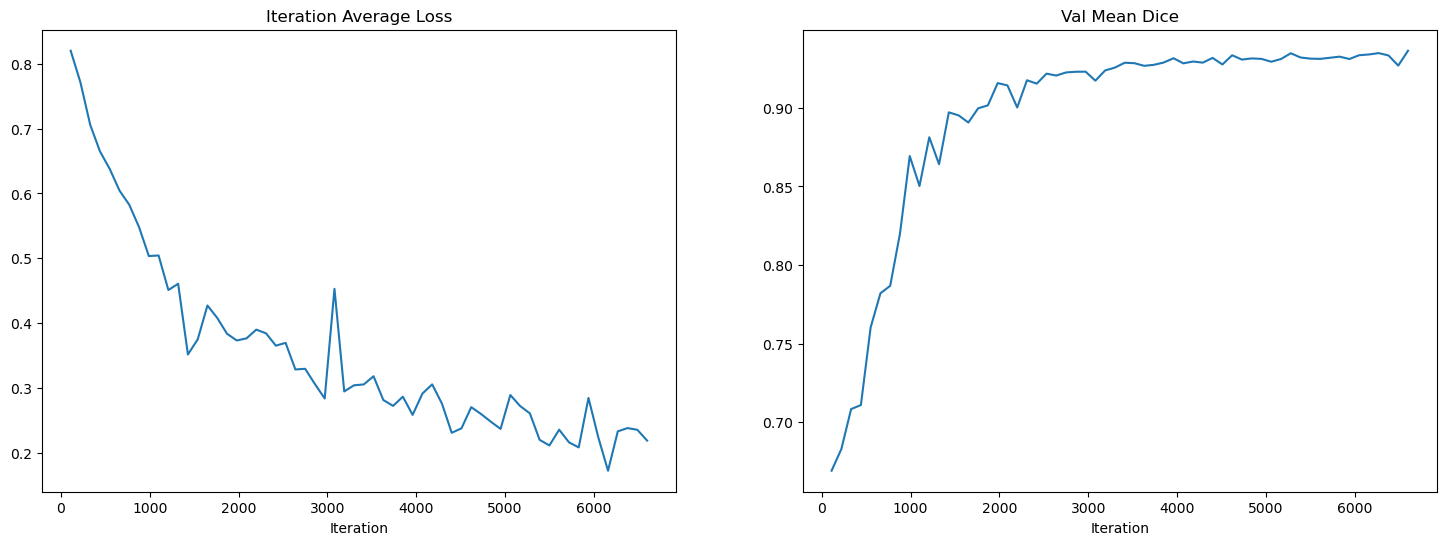

In [18]:
plt.figure("train", (18, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [19]:
import pandas as pd 
train_process= {
    'epoch_loss': epoch_loss_values,
    'metric_val': metric_values
}

train_df = pd.DataFrame(train_process)
train_df.to_excel("crop_all_12.xlsx")

In [20]:
test_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-250, a_max=600,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        # Spacingd(
        #     keys=["image", "label"],
        #     pixdim=(1.0, 1.0, 0.5),
        #     mode=("bilinear", "nearest"),
        # ),
        CropForegroundd(keys=["image","label"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_files, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=20)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, threshold=0.5),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./cropped_mask_tight", 
               output_postfix="_crop_mask_12", resample=False),
])

In [21]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (128, 128, 128)
        sw_batch_size = 16
        with torch.cuda.amp.autocast():
            test_data["pred"] = sliding_window_inference(
                test_inputs, roi_size, sw_batch_size, model, overlap=0.25)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

2023-01-11 06:17:03,550 INFO image_writer.py:193 - writing: cropped_mask_tight\MMH006_crop_tight\MMH006_crop_tight__crop_mask_12.nii.gz
2023-01-11 06:17:04,961 INFO image_writer.py:193 - writing: cropped_mask_tight\MMH007_crop_tight\MMH007_crop_tight__crop_mask_12.nii.gz
2023-01-11 06:17:06,506 INFO image_writer.py:193 - writing: cropped_mask_tight\MMH008_crop_tight\MMH008_crop_tight__crop_mask_12.nii.gz
2023-01-11 06:17:08,227 INFO image_writer.py:193 - writing: cropped_mask_tight\MMH009_crop_tight\MMH009_crop_tight__crop_mask_12.nii.gz
2023-01-11 06:17:09,730 INFO image_writer.py:193 - writing: cropped_mask_tight\MMH010_crop_tight\MMH010_crop_tight__crop_mask_12.nii.gz
2023-01-11 06:17:11,559 INFO image_writer.py:193 - writing: cropped_mask_tight\MMH011_crop_tight\MMH011_crop_tight__crop_mask_12.nii.gz
2023-01-11 06:17:12,889 INFO image_writer.py:193 - writing: cropped_mask_tight\MMH012_crop_tight\MMH012_crop_tight__crop_mask_12.nii.gz
2023-01-11 06:17:13,885 INFO image_writer.py:193

In [ ]:
device 

device(type='cuda')